# Trimodal data integration

In this tutorial, we will integrate a trimodal dataset sequenced by TEA-seq. This will provide a quick overview of how our model extends to trimodal data.

In [1]:
# For local use only
import os
os.environ['NUMBA_CACHE_DIR'] = '/scratch/st-jiaruid-1/yinian/tmp/' # https://github.com/scverse/scanpy/issues/2113
os.environ['MPLCONFIGDIR'] = "/scratch/st-jiaruid-1/yinian/tmp/"

In [2]:
import pickle

import anndata as ad
import numpy as np
import scanpy as sc
import scib
import sklearn

In [3]:
from scPairing import triscPairing

## Load the data

In these already-processed data, we have merged the five data batches into one AnnData object per modality.
For the scATAC-seq data, we created a common peak set using Signac.
The low-dimensional representations used as input to scPairing are already computed and stored in `.obsm`.

In [ ]:
!pip install gdown

!gdown

In [4]:
rna_adata = ad.read_h5ad('data/teaseq_rna.h5ad')
atac_adata = ad.read_h5ad('data/teaseq_atac.h5ad')
prot_adata = ad.read_h5ad('data/teaseq_prot.h5ad')

In [5]:
atac_adata.layers['binary'] = sklearn.preprocessing.binarize(atac_adata.layers['raw'])

For the representations, we use the first twenty dimensions of the Harmony-corrected PCA or LSI for the scRNA-seq and scATAC-seq, respectively.
For the protein data, we directly use the CLR-normalized counts as input.

In [6]:
rna_adata.obsm['X'] = rna_adata.obsm['harmony'][:, :20]
atac_adata.obsm['X'] = atac_adata.obsm['harmony'][:, :20]

## Make the model

As in our basic tutorial, we will not use the decoder.

In [7]:
model = triscPairing(
    rna_adata, atac_adata, prot_adata,
    mod1_type='rna', mod2_type='atac', mod3_type='protein',
    counts_layer=['raw', 'binary', 'raw'],
    transformed_obsm=['X', 'X', None],
    use_decoder=False,
    cosine_loss=True,
    seed=1
)

[2024-10-20 16:38:39,924] INFO - scPairing.models.utils: Set seed to 1.


In [8]:
model.train(epochs=300, batch_size=2000)

[2024-10-20 16:38:40,133] INFO - scPairing.logging_utils: UnsupervisedTrainer.__init__(Trimodel(
  (mod1_encoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (mod2_encoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (mod3_encoder): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_feat

[2024-10-20 16:38:46,046] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 0==========
[2024-10-20 16:38:46,048] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :        0.005
[2024-10-20 16:38:46,049] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-10-20 16:38:46,051] INFO - scPairing.trainers.trainer_utils: loss        :      41.85
[2024-10-20 16:38:46,053] INFO - scPairing.trainers.trainer_utils: contrastive :      14.29
[2024-10-20 16:38:46,055] INFO - scPairing.trainers.trainer_utils: KL          :    0.03909
[2024-10-20 16:38:46,056] INFO - scPairing.trainers.trainer_utils: mod1_loss   :      2.424
[2024-10-20 16:38:46,058] INFO - scPairing.trainers.trainer_utils: mod2_loss   :      1.211
[2024-10-20 16:38:46,060] INFO - scPairing.trainers.trainer_utils: mod3_loss   :      1.131
[2024-10-20 16:38:46,061] INFO - scPairing.trainers.trainer_utils: temp        :      14.29
[2024-10-20 16:38:46,063] INFO - scPairing.trainers.tra

[2024-10-20 16:42:12,381] INFO - scPairing.trainers.UnsupervisedTrainer: ==========Epoch 300==========
[2024-10-20 16:42:12,383] INFO - scPairing.trainers.UnsupervisedTrainer: lr          :      0.00371
[2024-10-20 16:42:12,384] INFO - scPairing.trainers.UnsupervisedTrainer: kl_weight   :        0.001
[2024-10-20 16:42:12,387] INFO - scPairing.trainers.trainer_utils: loss        :      12.36
[2024-10-20 16:42:12,389] INFO - scPairing.trainers.trainer_utils: contrastive :      33.71
[2024-10-20 16:42:12,392] INFO - scPairing.trainers.trainer_utils: KL          :      16.06
[2024-10-20 16:42:12,394] INFO - scPairing.trainers.trainer_utils: mod1_loss   :     0.4698
[2024-10-20 16:42:12,396] INFO - scPairing.trainers.trainer_utils: mod2_loss   :     0.4029
[2024-10-20 16:42:12,398] INFO - scPairing.trainers.trainer_utils: mod3_loss   :     0.1557
[2024-10-20 16:42:12,400] INFO - scPairing.trainers.trainer_utils: temp        :      33.71
[2024-10-20 16:42:12,402] INFO - scPairing.trainers.t

## Evaluate the model

First, get the representations from the comment latent space. The function returns a tuple of representations for the first modality then second modality.

In [9]:
latents = model.get_latent_representation()

Store the representations in the AnnDatas

In [10]:
rna_adata.obsm['mod1_features'] = atac_adata.obsm['mod1_features'] = prot_adata.obsm['mod1_features'] = latents[0]
rna_adata.obsm['mod2_features'] = atac_adata.obsm['mod2_features'] = prot_adata.obsm['mod2_features'] = latents[1]
rna_adata.obsm['mod3_features'] = atac_adata.obsm['mod3_features'] = prot_adata.obsm['mod3_features'] = latents[2]

Evaluate cell pairing for each pair of modalities using FOSCTTM

In [11]:
from scPairing.eval_utils import foscttm

In [12]:
# Between RNA and ATAC
res = foscttm(latents[0], latents[1])
res[0].mean(), res[1].mean()

(0.024102377861679694, 0.024025483914726135)

In [13]:
# Between RNA and epitope
res = foscttm(latents[0], latents[2])
res[0].mean(), res[1].mean()

(0.04739610356820456, 0.04834120413463236)

In [14]:
# Between ATAC and epitope
res = foscttm(latents[1], latents[2])
res[0].mean(), res[1].mean()

(0.03844467689875766, 0.040389747403953166)

### Evaluate clustering and co-embedding of cells

For clustering, we can concatenate the two representations together for a joint representation. We will use the protein AnnData for visualization to see expression of key marker proteins.

In [15]:
concat = np.concatenate(latents, axis=1)
prot_adata.obsm['concat'] = concat

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


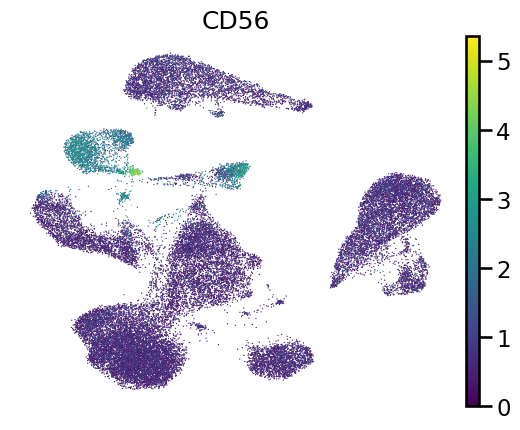

In [16]:
sc.pp.neighbors(prot_adata, use_rep='concat', random_state=1)
sc.tl.umap(prot_adata, min_dist=0.5, random_state=1)
sc.pl.umap(prot_adata, color='CD56', ncols=1, frameon=False)

We will load our own manual annotations of the cell types based on the marker epitopes from the TEA-seq publication and other known marker epitopes. 

In [17]:
with open('data/teaseq_cell_types.pkl', 'rb') as f:
    prot_adata.obs['cell_type'] = pickle.load(f)

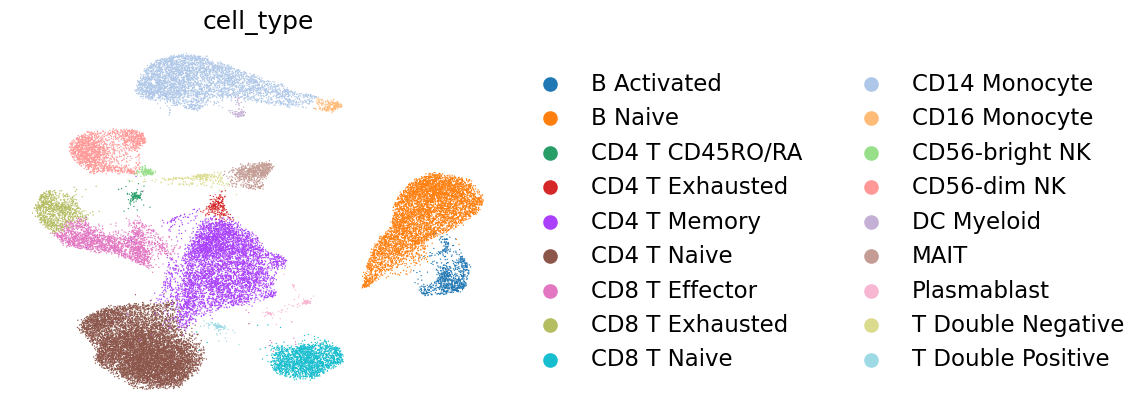

In [18]:
sc.pl.umap(prot_adata, color='cell_type', frameon=False)

Next, we can verify that the modalities mix in the embedding space

In [19]:
concat_feat = np.concatenate(latents)

concat = ad.concat([prot_adata, prot_adata, prot_adata], label='modality', keys=['RNA', 'ATAC', 'Epitope'])
concat.obsm['concat_feat'] = concat_feat

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
sc.pp.neighbors(concat, use_rep='concat_feat', random_state=0)
sc.tl.umap(concat, min_dist=0.5, random_state=0)

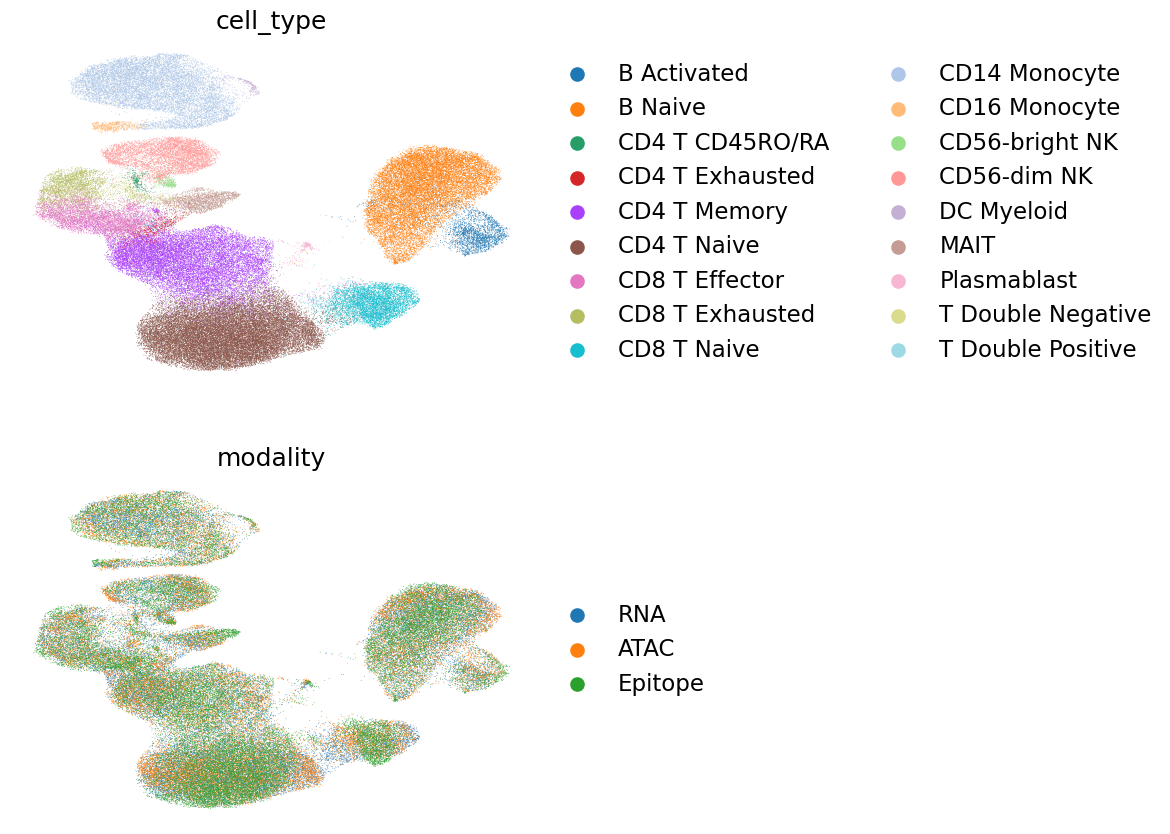

In [21]:
sc.pl.umap(concat, color=['cell_type', 'modality'], ncols=1, frameon=False)

Use the Local Inverse Simpson's Index (LISI) to measure the extent of modality mixing.

In [22]:
scib.me.ilisi_graph(concat, batch_key="modality", type_="knn")

/arc/project/st-jiaruid-1/yinian/test_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


0.5969587035193207